
##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");


In [160]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [161]:
# This is helper cell that defines code checking (testing) function Check()
# Please run it once, but you do not need to understand it.
!pip install prog_edu_assistant_tools
import re
import sys
import jinja2
from IPython.core import display
from google.colab import _message as google_message
from prog_edu_assistant_tools.magics import report, autotest, CaptureOutput
def GetNotebook():
  """Downloads the ipynb source of Colab notebook"""
  notebook = google_message.blocking_request(
    "get_ipynb", request="", timeout_sec=120)["ipynb"]
  return notebook

def RunInlineTests(submission_source, inlinetests):
  """Runs an inline test."""
  errors = []
  for test_name, test_source in inlinetests.items():
    #print(f'Running inline test {test_name}:\n{test_source}', file=sys.stderr)
    with CaptureOutput() as (stdout, stderr):
      try:
        env = {}
        exec(submission_source, globals(), env)
        exec(test_source, globals(), env)
      except AssertionError as e:
        errors.append(str(e))
      if len(stderr.getvalue()) > 0:
        errors.append('STDERR:' + stderr.getvalue())
  if len(errors) > 0:
    results = {'passed': False, 'error': '\n'.join(errors)}
  else:
    results = {'passed': True}
  template_source = """
  <h4 style='color: #387;'>Your submission</h4>
  <pre style='background: #F0F0F0; padding: 3pt; margin: 4pt; border: 1pt solid #DDD; border-radius: 3pt;'>{{ formatted_source }}</pre>
  <h4 style='color: #387;'>Results</h4>
  {% if 'passed' in results and results['passed'] %}
  &#x2705;
  Looks OK.
  {% elif 'error' in results %}
  &#x274c;
  {{results['error'] | e}}
  {% else %}
  &#x274c; Something is wrong.
  {% endif %}"""
  template = jinja2.Template(template_source)
  html = template.render(formatted_source=submission_source, results=results)
  return html

def Check(exercise_id):
  """Checks one exercise against embedded inline tests."""
  def _get_exercise_id(cell):
    if 'metadata' in cell and 'exercise_id' in cell['metadata']:
      return cell['metadata']['exercise_id']
    if 'source' not in cell or 'cell_type' not in cell or cell['cell_type'] != 'code':
      return None
    source = ''.join(cell['source'])
    m = re.search('(?m)^# *EXERCISE_ID: [\'"]?([a-zA-Z0-9_.-]*)[\'"]? *\n', source)
    if m:
      return m.group(1)
    return None
  notebook = GetNotebook()
  # 1. Find the first cell with specified exercise ID.
  found = False
  for (i, cell) in enumerate(notebook['cells']):
    if _get_exercise_id(cell) == exercise_id:
      found = True
      break
  if not found:
    raise Exception(f'exercise {exercise_id} not found')

  submission_source = ''.join(cell['source'])  # extract the submission cell
  submission_source = re.sub(r'^%%(solution|submission)[ \t]*\n', '', submission_source)  # cut %%solution magic
  inlinetests = {}
  if 'metadata' in cell and 'inlinetests' in cell['metadata']:
    inlinetests = cell['metadata']['inlinetests']
  if len(inlinetests) == 0:
    j = i+1
    # 2. If inline tests were not present in metadata, find the inline tests
    # that follow this exercise ID.
    while j < len(notebook['cells']):
      cell = notebook['cells'][j]
      if 'source' not in cell or 'cell_type' not in cell or cell['cell_type'] != 'code':
        j += 1
        continue
      id = _get_exercise_id(cell)
      source = ''.join(cell['source'])
      if id == exercise_id:
        # 3. Pick the last marked cell as submission cell.
        submission_source = source  # extract the submission cell
        submission_source = re.sub(r'^%%(solution|submission)[ \t]*\n', '', submission_source)  # cut %%solution magic
        j += 1
        continue
      m = re.match(r'^%%inlinetest[ \t]*([a-zA-Z0-9_]*)[ \t]*\n', source)
      if m:
        test_name = m.group(1)
        test_source = source[m.end(0):]  # cut %%inlinetest magic
        # 2a. Store the inline test.
        inlinetests[test_name] = test_source
      if id is not None and id != exercise_id:
        # 4. Stop at the next exercise_id.
        break
      j += 1
  html = RunInlineTests(submission_source, inlinetests)
  return display.HTML(html)

In [162]:
# MASTER ONLY

%load_ext prog_edu_assistant_tools.magics
from prog_edu_assistant_tools.magics import report, autotest, CaptureOutput

The prog_edu_assistant_tools.magics extension is already loaded. To reload it, use:
  %reload_ext prog_edu_assistant_tools.magics


# Fashion MNIST Classifier Using Keras

The code below was presented during the practical part of the Google Elevate class about Machine Learning.

If your notebook is marked as "Read only" or is opened in Playground mode, please make a copy in Drive (see the "File" menu).
If you opened the notebook from Google Classroom, it should be editable already.

Run the cells one by one to download the dataset, train the model and inspect some predictions.

## Initialize

In [163]:
# Some useful libraries.
import itertools
from matplotlib import pyplot as plt
import numpy as np

In [164]:
# Make an explicit choice of Tensorflow 2.0. Note that many of the tutorials
# on the interner may use 1.0 that has different API.
%tensorflow_version 2.x

In [165]:
import tensorflow as tf
print(f'TF version={tf.__version__}')
# Do you want to train with a GPU? Simply "Change runtime type" in the "Runtime"
# menu and re-execte the cells.
print(f'GPUS={tf.config.list_physical_devices("GPU")}')

TF version=2.4.1
GPUS=[]


## Download and Inspect the Data

In [166]:
# Download MNIST dataset from the web.
# See more datasets on https://www.tensorflow.org/datasets/datasets
import tensorflow_datasets as tfds
ds, info = tfds.load('fashion_mnist', with_info=True)

In [167]:
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [168]:
# Datasets are iterables. Let's fetch the first example:
for example in ds['train']:
    break
example.keys()

dict_keys(['image', 'label'])

Image shape=(28, 28, 1)


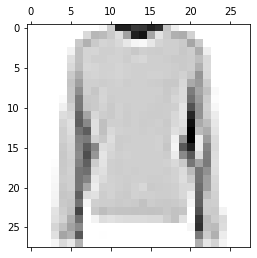

In [169]:
print(f'Image shape={example["image"].shape}')
# The image has a last dimension of `1` because it contains a single grayscale
# channel. Make the shape (28, 28) for drawing with Matplotlib.
plt.matshow(example['image'][:,:,0], cmap='Greys')

In [170]:
# The label is specified as a number.
print(example['label'])
# Use .numpy() to extract the number.
print(example['label'].numpy())

tf.Tensor(2, shape=(), dtype=int64)
2


In [171]:
# The additional data in `info` lets us convert that number to a string label.
info.features['label'].names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

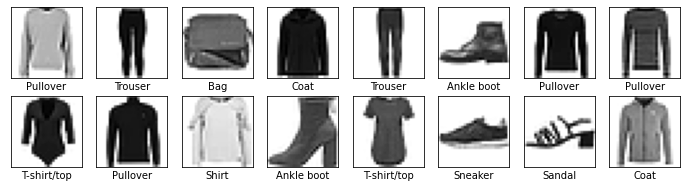

In [172]:
# Let's plot some more examples...
rows, cols = 2, 8
plt.figure(figsize=(1.5*cols, 1.5*rows))
for i, example in enumerate(itertools.islice(ds['train'], rows*cols)):
    plt.subplot(rows, cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(example['image'].numpy().reshape((28, 28)), cmap=plt.cm.binary)
    label_index = example['label'].numpy()
    plt.xlabel(info.features['label'].names[label_index])

## Define the Model

In [173]:
# Define the model; see presentation for additional explanations.
model = tf.keras.Sequential([
    # We need to specify the input shape of the first layer only.
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [174]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In [175]:
# Keras .fit() function expects dataset containing (data, label).
# This function maps the dictionary from tfds to this expected tuple.
def map_features(example):
    return (
        example['image'],
        example['label'],
    )
# Train the model with batches of size 128.
train_ds = ds['train'].map(map_features).batch(128)
model.fit(train_ds, epochs=2)
# Note: you can repeat this step with more epochs to further train the model.

Epoch 1/2
469/469 [==============================] - 8s 17ms/step - loss: 14.8553 - accuracy: 0.6843
Epoch 2/2
469/469 [==============================] - 2s 4ms/step - loss: 0.9115 - accuracy: 0.7247


## Inspect some Predictions

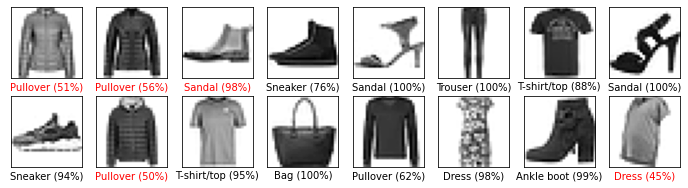

In [176]:
# Show predictions with their "confidence" (note that this confidence is simply
# the value of the largest activation in the output layer and this is by no
# means calibrated, sometimes you will even see predictions with ~100%
# "confidence" that are still wrong...)
# Incorrect predictions are shown with red text.
rows, cols = 2, 8
plt.figure(figsize=(1.5*cols, 1.5*rows))
examples = []
for i, example in enumerate(itertools.islice(ds['test'], rows*cols)):
    examples.append(example)
    plt.subplot(rows, cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(example['image'].numpy().reshape((28, 28)), cmap=plt.cm.binary)
    # tf.expand_dims() changes the shape (28, 28, 1) -> (1, 28, 28, 1)
    # This is needed because the model expects a batch of images (batch
    # dimension is the first dimension).
    prediction = model.predict(tf.expand_dims(example['image'], 0))[0]
    predicted_index = prediction.argmax()
    predicted_name = info.features['label'].names[predicted_index]
    label_index = example['label']
    predicted_pct = int(100 * prediction.max())
    fmt_kwargs = {}
    if example['label'].numpy() != predicted_index:
        fmt_kwargs['color'] = 'red'
    plt.xlabel(f'{predicted_name} ({predicted_pct}%)', **fmt_kwargs)

Prediction=Sandal Label=Ankle boot


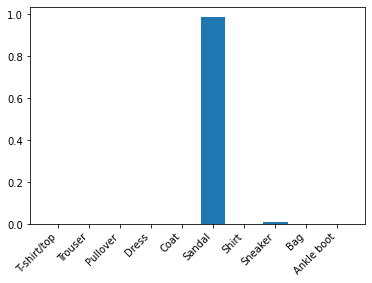

In [177]:
# Inspect an individual example from above.
example = examples[2]
pred = model.predict(tf.expand_dims(example['image'], 0))[0]
plt.bar(range(len(pred)), pred)
plt.xticks(range(len(pred)), info.features['label'].names)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
print('Prediction={} Label={}'.format(
    info.features['label'].names[pred.argmax()],
    info.features['label'].names[example['label']],
))


## Check your understanding: simple quizes

The quizzes were designed not require looking up any external API documentation, so it should be sufficient to understand the material above and basics of Python. Please review the material above to look for the hints.

### Quiz ML.0

How many training and testing examples does the dataset have? Complete the function definitions below to return the number. Make sure the functions accept
the dataset variable `ds` that you have defined above in the notebook.

**Hint**: Dataset is a dictionary with each value being an iterable of examples. Python has a standard function `len` for computing length of lists and iterables.


In [178]:
%%solution
# EXERCISE_ID: exercise_ml_0
def num_training_examples(dataset):
  # BEGIN SOLUTION
  return len(dataset['train'])
  # END SOLUTION
  """ # BEGIN PROMPT
  return ...
  """ # END PROMPT

def num_testing_examples(dataset):
  # BEGIN SOLUTION
  return len(dataset['test'])
  # END SOLUTION
  """ # BEGIN PROMPT
  return ...
  """ # END PROMPT

In [179]:
%%inlinetest InlineTest_ml0

assert 'num_training_examples' in globals(), f"Have you defined the function 'num_training_examples'?"
assert str(num_training_examples.__class__) == "<class 'function'>", f"Have you defined a function 'num_training_examples'? Found a {num_training_examples.__class__} instead"
import tensorflow_datasets as tfds
_ds, info = tfds.load('fashion_mnist', with_info=True)
try:
  ans = num_training_examples(_ds)
  assert ans == 60000, f"Your function 'num_training_examples' returns {ans}, while the expected answer is 60000"
except AssertionError as e:
  raise e
except Exception as e:
  assert False, f"Your function 'num_training_examples' does not accept the dataset dictionary `ds` and raises an exception: {e}. Please try to pass `ds` to your function."
try:
  ans = num_testing_examples(_ds)
  assert ans == 10000, f"Your function 'num_testing_examples' returns {ans}, while the expected answer is 10000"
except AssertionError as e:
  raise e
except Exception as e:
  assert False, f"Your function 'num_testing_examples' does not accept the dataset dictionary `ds` and raises an exception: {e}. Please try to pass `ds` to your function."
# A dummy dataset for testing.
# TODO(salikh): Maybe create an actual dataset for more realistic testing? https://www.tensorflow.org/datasets/add_dataset
_small_ds = {'train': [1,2,3], 'test': [1,2]}
try:
  ans = num_training_examples(_small_ds)
  assert ans != 60000,  "Are you counting the examples in global dataset instead of the passed one?"
  assert ans != 2, "Are you couting training and testing examples correctly? It seems they are mixed up"
  assert ans == len(_small_ds['train']), "Are you counting the training examples correctly?"
except AssertionError as e:
  raise e
except Exception as e:
  assert False, f"Your function 'num_training_examples' does not accept an arbitrary dataset and raises an exception: {e}."
try:
  ans = num_testing_examples(_small_ds)
  assert ans != 10000,  "Are you counting the examples in global dataset instead of the passed one?"
  assert ans != 3, "Are you couting training and testing examples correctly? It seems they are mixed up"
  assert ans == len(_small_ds['test']), "Are you counting the testing examples correctly?"
except AssertionError as e:
  raise e
except Exception as e:
  assert False, f"Your function 'num_testing_examples' does not accept an arbitrary dataset and raises an exception: {e}."

In [180]:
result, log = %autotest InlineTest_ml0
print(result.results)

{'passed': True}


In [181]:
report(InlineTest_ml0, results=result.results, source=submission_source.source)

In [182]:
# Run this cell to check your solution.
# If you get an error 'Check not defined', make sure you have run all preceding
# cells once (Runtime -> Run before)
Check('exercise_ml_0')

In [183]:
%%submission
def num_training_examples(dataset):
  return 60000

In [184]:
result, log = %autotest InlineTest_ml0
print(result.results)
report(InlineTest_ml0, results=result.results, source=submission_source.source)

{'error': AssertionError('Are you counting the examples in global dataset instead of the passed one?',), 'passed': False}


In [185]:
num_training = num_training_examples(ds)
num_testing = num_testing_examples(ds)
print(f"{num_training} training examples, {num_testing} testing examples")

60000 training examples, 10000 testing examples


Answer: Please check that the above cell prints `60000 training examples, 10000 testing examples`.

### Quiz ML.1

Extract the training example number 5 (counting from 0) and store it into a variable `example5`.

**Hint:** Remember that you have loaded the datasets into variables `ds` and `info`. Scroll and re-read the cells above to see some fragments of code dealing with examples. You may also find function `itertools.islice` useful, 
but it is not required.


In [186]:
%%solution
# EXERCISE_ID: exercise_ml_1
# BEGIN SOLUTION
example5 = list(itertools.islice(ds['train'], 6))[5]
# END SOLUTION
""" # BEGIN PROMPT
example5 = ...
""" # END PROMPT

In [187]:
%%inlinetest InlineTest_ml1
assert 'example5' in globals(), f"Have you defined the variable 'example5'?"
assert str(example5.__class__) == "<class 'dict'>", f"Have you defined a variable 'example5' to contain an example (dictionary)? Found a {example5.__class__} instead"
assert ('image' in example5) and ('label' in example5), f"Have you assigned an example to the variable 'example5'? Example is a dictionary with keys 'image' and 'label'."
assert example5['label'] != 1, f"Have you extracted a #5 example from testing dataset? Quiz asked for training example. Or you may have off-by-one error."
assert example5['label'] != 2, f"Have you extracted an example #5 counting from 0? You may have off-by-one error."
assert example5['label'] == 9, f"Have you extracted an example #5 from training data set counting from 0? Expected to see an Ankle boot, but got {info.features['label'].names[example5['label']]}"

In [188]:
result, log = %autotest InlineTest_ml1
print(result.results)

{'passed': True}


In [189]:
report(InlineTest_ml1, results=result.results, source=submission_source.source)

In [190]:
# Run this cell to check your solution.
# If you get an error 'Check not defined', make sure you have run all preceding
# cells once (Runtime -> Run before)
Check('exercise_ml_1')

In [191]:
%%submission
# Incorrect submission
example5 = 1.618

In [192]:
# Test the incorrect submission against an autograder test
result, log = %autotest InlineTest_ml1
print(result.results)

{'error': AssertionError("Have you defined a variable 'example5' to contain an example (dictionary)? Found a <class 'float'> instead",), 'passed': False}


In [193]:
report(InlineTest_ml1, results=result.results, source=submission_source.source)

### Quiz ML.2

Visualize the training example #5 that you have extracted above:

* Plot the image of the example
* Print the label of the example (or include the label into the plot)

Complete the definition of the function `VisualizeExample` below and confirm that the function works with the `example5` that you have extracted above.

**Hint**: The mapping of label class indices and human-readable class names is in `info.features['label'].names`. Visualization of image data can be done with `plt.matshow` or `plt.imshow`. You may want to use a grayscape colormap in visualization.


In [194]:
%%solution
# EXERCISE_ID: exercise_ml_2
def VisualizeExample(example):
  # BEGIN SOLUTION
  plt.matshow(np.squeeze(example['image']), cmap=plt.cm.binary)
  plt.xlabel(info.features['label'].names[example5['label']])
  plt.show()
  # END SOLUTION
  """ # BEGIN PROMPT
  label_index = ...
  label = info.features['label'].names[label_index]
  plt.matshow(...)
  plt.xlabel(label)
  plt.show()
  """ # END PROMPT

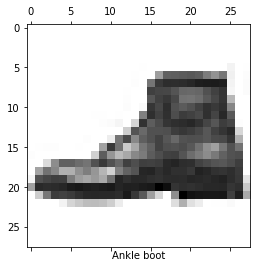

In [195]:
VisualizeExample(example5)

**Answer**: Please check that you see a picture of a boot, and see a label 'Ankle boot'.

### Quiz ML.3

Run the model that was trained above (`model`) giving it the example number 5 (`example5`) as an input and print the predicted label. Most of the time, you should see a correct prediction.

Complete the definition of the function `PredictExample()` below and verify that it works with `example5`.


In [196]:
%%solution
# EXERCISE_ID: exercise_ml_3
def PredictExample(model, example):
  # BEGIN SOLUTION
  prediction = model.predict(tf.expand_dims(example5['image'], 0))[0]
  predicted_index = prediction.argmax()
  return info.features['label'].names[predicted_index]
  # END SOLUTION
  """ # BEGIN PROMPT
  prediction = model.predict(...)
  predicted_index = ...
  return info.features['label'].names[predicted_index]
  """ # END PROMPT

In [197]:
%%inlinetest InlineTest_ml3
assert 'PredictExample' in globals(), f"Have you defined a function 'PredictExample'?"
assert str(PredictExample.__class__) == "<class 'function'>", f"Have you defined a function 'PredictExample'? Found a {PredictExample.__class__} instead"

if 'ds' not in globals():
  import tensorflow_datasets as tfds
  import itertools
  ds, info = tfds.load('fashion_mnist', with_info=True)
if 'model' not in globals():
  model = tf.keras.Sequential([
    # We need to specify the input shape of the first layer only.
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  def map_features(example):
    return (
        example['image'],
        example['label'],
    )
  # Train the model with batches of size 128.
  train_ds = ds['train'].map(map_features).batch(128)
  model.fit(train_ds, epochs=1)

assert PredictExample(model, list(itertools.islice(ds['train'], 6))[5]) in info.features['label'].names, "Did you return a human-readable label?"

In [198]:
# Run this cell to check your solution.
# If you get an error 'Check not defined', make sure you have run all preceding
# cells once (Runtime -> Run before)
Check('exercise_ml_3')

In [199]:
print(PredictExample(model, example5))

Ankle boot


**Answer**: You should see the label of one of the classes, and most of the time it should be the correct class Ankle boot.

### Quiz ML.4

Create a function that takes a test dataset (an iterable of examples) and a model as input and returns the accuracy of the model on that dataset.

In [200]:
%%solution
# EXERCISE_ID: exercise_ml_4
def Accuracy(model, examples):
  total = 0.0
  correct = 0.0
  for example in examples:
    # BEGIN SOLUTION
    prediction = model.predict(tf.expand_dims(example['image'], 0))[0]
    predicted_index = prediction.argmax()
    label = example['label'].numpy()
    total += 1
    correct += 1 if predicted_index == label else 0
    # END SOLUTION
    """ # BEGIN PROMPT
    prediction = model.predict(tf.expand_dims(example['image'], 0))[0]
    predicted_index = ...
    label_index = example['label'].numpy()
    total += 1
    correct += 1 if ... else 0
    """ # END PROMPT
  return correct/total

Now compute the accuracy on the first 10 testing examples:

In [201]:
print(Accuracy(model, itertools.islice(ds['test'], 10)))

0.6


**Answer**: Visualize the first 10 examples from the test set with their true labels and predictions, and confirm that your accuracy computation above is correct. You should see the number above matching the fraction of correct examples (incorrect examples are marked in read), so if the accuracy was 0.8, then you should see 8 correctly predicted examples, and 2 incorrect (red).

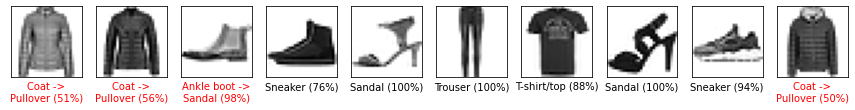

In [202]:
rows, cols = 1, 10
plt.figure(figsize=(1.5*cols, 1.5*rows))
examples = []
for i, example in enumerate(itertools.islice(ds['test'], rows*cols)):
    examples.append(example)
    plt.subplot(rows, cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(example['image'].numpy().reshape((28, 28)), cmap=plt.cm.binary)
    # tf.expand_dims() changes the shape (28, 28, 1) -> (1, 28, 28, 1)
    # This is needed because the model expects a batch of images (batch
    # dimension is the first dimension).
    prediction = model.predict(tf.expand_dims(example['image'], 0))[0]
    predicted_index = prediction.argmax()
    predicted_name = info.features['label'].names[predicted_index]
    label_index = example['label']
    predicted_pct = int(100 * prediction.max())
    fmt_kwargs = {}
    true_index = example['label'].numpy()
    true_name = info.features['label'].names[true_index]
    if true_index != predicted_index:
      fmt_kwargs['color'] = 'red'
      plt.xlabel(f'{true_name} ->\n{predicted_name} ({predicted_pct}%)', **fmt_kwargs)
    else:
      plt.xlabel(f'{predicted_name} ({predicted_pct}%)', **fmt_kwargs)

### Quiz ML.5

Create a constant predictor model that always predicts the same class no matter what input data is provided, and make it compatible with the `model.predict()`.

**Hint** Try to look at the shape of tensors returned by `model.predict()` using the field accessor `.shape` to better understand the shape of the data its `predict()` function receives and returns. The constant predictor should return a data in the same shape, but constructed from constants. You may need to check Numpy or Tensorflow documentation to find out how to create a constant of a given shape.

In [203]:
%%solution
# EXERCISE_ID: exercise_ml5
class ConstantPredictor:
  def __init__(self, num_classes, output):
    # Total number of classes. This is necessary to define the output shape.
    self.num_classes = num_classes
    # The index of the class that this predictor will always return
    self.output = output

  def predict(self, input_tensor):
    # BEGIN SOLUTION
    batch_size = input_tensor.shape[0]
    ans = np.zeros((batch_size, self.num_classes))
    ans[0, self.output] = 1.0
    return ans
    # END SOLUTION
    """ # BEGIN PROMPT
    return ...
    """ # END PROMPT

'ClassDef' object has no attribute 'value'


In [204]:
%%inlinetest InlineTest_ml5

assert 'ConstantPredictor' in globals(), f"Did you define the class 'ConstantPredictor'?"
assert str(ConstantPredictor.__class__) == "<class 'type'>", f"Did you define 'ConstantPredictor' as class? Got {str(ConstantPredictor.__class__)} instead."
#assert str(ConstantPredictor.predict.__class__) == 'function', f"Did you implement 'predict' method in ConstantPredictor class?"
_predictor = ConstantPredictor(5, 3)
_input = tf.constant(0.0, shape=(1,28,28,1), dtype=float)
ans = _predictor.predict(_input)
try:
  ans.shape
except AttributeError:
  assert False, f"Did you return a tensor (or numpy array)? Got {str(ans.__class__)} instead"
assert len(ans.shape) == 2, f"Did you return a constant tensor of a right shape? Expected shape is (batch_size, num_classes), but got {ans.shape} when giving input of shape {_input.shape}"
assert ans.shape[0] == 1, f"Did you return a constant tensor of a right shape? Expected shape is (batch_size, num_classes), but got {ans.shape} when giving input of shape {_input.shape}"
assert ans.shape[1] == 5, f"Did you return a constant tensor of a right shape? Expected shape is (batch_size, num_classes), but got {ans.shape} when giving input of shape {_input.shape}"
assert ans.argmax() == 3, f"Did you set the prediction of the output class to 1? Got prediction of the wrong class"

In [205]:
# Run this to check your answer.
# If you see an error about 'Check' not defined, pelase make sure you have run
# cells at the top of the notebook, e.g. by Runtime -> Run above.
Check('exercise_ml5')

In [206]:
%%submission
class ConstantPredictor:
  def __init__(self, num_classes, output):
    # Total number of classes. This is necessary to define the output shape.
    self.num_classes = num_classes
    # The index of the class that this predictor will always return
    self.output = output

  def predict(self, input_tensor):
    return self.output

In [207]:
result, log = %autotest InlineTest_ml5
print(result.results)
report(InlineTest_ml5, results=result.results, source=submission_source.source)

{'error': AssertionError("Did you return a tensor (or numpy array)? Got <class 'int'> instead",), 'passed': False}


In [208]:
# Find out the index of 'Coat' class.
label_indices = {v: k for k, v in enumerate(info.features['label'].names)}
coat_index = label_indices['Coat']

# Create a constant predictor that always returns 'Coat' answer.
const_model = ConstantPredictor(info.features['label'].num_classes, coat_index)

Now compute the accuracy of the constant model on the first 10 test examples:

In [209]:
Accuracy(const_model, itertools.islice(ds['test'], 10))

0.3

**Answer**: Make sure you get 0.3 as the accuracy of the constant model on first 10 test examples.

### Quiz ML.6

This task goes a little bit farther and requires you to review the theoretical part of the ML presentation. 

Let's assume that one of the predicted classes is more important than others,
e.g. consider a question: "Is this example of Ankle boot?".
This is called _one-vs-others model_, where a multiclass predictor
is used to predict an answer to a binary question. For binary classifiers, we can compute precision and recall, which may also be helpful to understand the performance of the original multiclass model with respect to a single class.

Your task is to complete a definition of the function `PrecisionAndRecall` that takes a multiclass model (e.g. `model` defined above in the notebook or the constant predictor from previous quiz), the iterable of examples, and the class index to be considered as one-vs-others. The function should return two numbers:

* Precision (fraction of correct predictions among the examples predicted with the given class)
* Recall (fraction of correct predictions among the examples having the given class)

In [210]:
%%solution
# EXERCISE_ID: exercise_ml6
def PrecisionAndRecall(model, examples, target_index):
  # BEGIN SOLUTION
  positive_count = 0
  predicted_count = 0
  correct_count = 0
  for example in examples:
    prediction = model.predict(tf.expand_dims(example['image'], 0))[0]
    predicted_index = prediction.argmax()
    #print('predicted', predicted_index)
    true_index = example['label'].numpy()
    #print('true', true_index)
    if predicted_index == target_index:
      predicted_count += 1
      if predicted_index == true_index:
        correct_count += 1
    if true_index == target_index:
      positive_count += 1
  
  precision = correct_count/predicted_count if predicted_count > 0 else 0.0
  recall = correct_count/positive_count if positive_count > 0 else 0.0
  return precision, recall
  # END SOLUTION
  """ # BEGIN PROMPT
  precision = ...
  recall = ...
  return precision, recall
  """ # END PROMPT

In [211]:
# MASTER ONLY
_predictor = _DeterministicPredictor(10)
_examples = itertools.islice(ds['train'], 50)
_target_index = 2
_true_labels = [example['label'].numpy() for example in itertools.islice(ds['train'], 50)]
_pred_labels = [_predictor.predict(tf.expand_dims(example['image'], 0))[0].argmax() for example in itertools.islice(ds['train'], 50)]
print(PrecisionAndRecall(_predictor, _examples, _target_index))

(0.5, 0.2222222222222222)


In [212]:
# MASTER ONLY
_target_index = 2
print('prediction correct(not using target index)', np.sum([1 if tr == pr else 0 for tr, pr in zip(_true_labels, _pred_labels)]))
print('TP', np.sum([1 if tr == pr and tr == 2 else 0 for tr, pr in zip(_true_labels, _pred_labels)]))
print('FP', np.sum([1 if pr == 2 and tr != 2 else 0 for tr, pr in zip(_true_labels, _pred_labels)]))
print('FN', np.sum([1 if pr != 2 and tr == 2 else 0 for tr, pr in zip(_true_labels, _pred_labels)]))
print('TN', np.sum([1 if pr != 2 and tr != 2 else 0 for tr, pr in zip(_true_labels, _pred_labels)]))
print('predicted(_target_index)', np.sum([1 if pr == 2 else 0 for tr, pr in zip(_true_labels, _pred_labels)]))
print('positive(_target_index)', np.sum([1 if tr == 2 else 0 for tr, pr in zip(_true_labels, _pred_labels)]))
print('expected precision: ', 2/4)
print('expected recall: ', 2/9)

prediction correct(not using target index) 8
TP 2
FP 2
FN 7
TN 39
predicted(_target_index) 4
positive(_target_index) 9
expected precision:  0.5
expected recall:  0.2222222222222222


In [222]:
%%inlinetest InlineTest_ml6
import math
assert 'PrecisionAndRecall' in globals(), f"Did you define the function 'PrecisionAndRecall'?"
assert str(PrecisionAndRecall.__class__) == "<class 'function'>", f"Did you define 'PrecisionAndRecall' as function? Got {str(PrecisionAndRecall.__class__)} instead."
class _TestConstantPredictor:
  def __init__(self, num_classes, output):
    # Total number of classes. This is necessary to define the output shape.
    self.num_classes = num_classes
    # The index of the class that this predictor will always return
    self.output = output

  def predict(self, input_tensor):
    # BEGIN SOLUTION
    batch_size = input_tensor.shape[0]
    ans = np.zeros((batch_size, self.num_classes))
    ans[0, self.output] = 1.0
    return ans

_predictor = _TestConstantPredictor(10, 2)
# First 10 training examples: 2, 1, 8, 4, 1, 9, 2, 2, 0, 2 => 4 examples with label 2.
try:
  _ans = PrecisionAndRecall(_predictor, itertools.islice(ds['train'], 10), 2)
except Exception as e:
  assert False, f"Did you compute precision and recall correctly, expected two numbers, but got an exception instead: {e}"
#print(_ans)
assert str(_ans.__class__) == "<class 'tuple'>", f"Did you return two numbers, i.e. a tuple of precision and recall?"
assert len(_ans) == 2, f"Did you return two numbers, i.e. a tuple of precision and recall?"
_precision, _recall = _ans[0], _ans[1]
assert _recall == 1.0, f"Did you compute recall correctly? expected to get 1.0 recall on constant predictor that returns a target label, but got {_recall} instead"
assert abs(_precision - 0.4) < 0.00001, f"Did you compute precision correctly? Should be the number of examples where both predicted and true index == target index divided by number of examples where predicted index == target index"

# Test only on 2 first examples
try:
  _ans = PrecisionAndRecall(_predictor, itertools.islice(ds['train'], 2), 2)
except Exception as e:
  assert False, f"Did you compute precision and recall correctly, expected two numbers, but got an exception instead: {e}"
assert len(_ans) == 2, f"Did you return two numbers, i.e. a tuple of precision and recall?"
_precision, _recall = _ans[0], _ans[1]
assert _recall == 1.0, f"Did you compute recall correctly, expected to get 1.0 recall on constant predictor that returns a target label, but got {_recall} instead"
assert abs(_precision - 0.5) < 0.00001, f"Did you compute precision correctly? Should be the number of examples where both predicted and true index == target index divided by number of examples where predicted index == target index"

try:
  # 3 does not occur in first 10 training examples.
  _ans = PrecisionAndRecall(_predictor, itertools.islice(ds['train'], 10), 3)
except Exception as e:
  assert False, f"Did you compute precision and recall correctly, expected two numbers, but got an exception instead: {e}"
assert len(_ans) == 2, f"Did you return two numbers, i.e. a tuple of precision and recall?"
_precision, _recall = _ans[0], _ans[1]
assert _precision == 0.0, f"Did you compute precision correctly? expected to get 0.0 precision on constant predictor that returns a label that does not occur in the example set, but got {_precision} instead"

class _DeterministicPredictor:
  """Nonsence, but deterministic predictor."""
  def __init__(self, num_classes):
    # Total number of classes. This is necessary to define the output shape.
    self.num_classes = num_classes

  def predict(self, input_tensor):
    # BEGIN SOLUTION
    batch_size = input_tensor.shape[0]
    ans = np.zeros((batch_size, self.num_classes))
    #print(np.sum(input_tensor))
    output_index = int(int(np.sum(input_tensor)/10.0)%self.num_classes)
    #print(output_index)
    ans[:, output_index] = 1.0
    #print(ans)
    return ans
_predictor = _DeterministicPredictor(10)
try:
  _ans = PrecisionAndRecall(_predictor, itertools.islice(ds['train'], 50), 2)
except Exception as e:
  assert False, f"Did you compute precision and recall correctly, expected two numbers, but got an exception instead: {e}"
#print(_ans)
assert str(_ans.__class__) == "<class 'tuple'>", f"Did you return two numbers, i.e. a tuple of precision and recall?"
assert len(_ans) == 2, f"Did you return two numbers, i.e. a tuple of precision and recall?"
_precision, _recall = _ans[0], _ans[1]
print('precision', _precision, ', recall', _recall)
assert abs(_precision - 0.5) < 0.00001, f"Did you compute precision correctly? Should be the number of examples where both predicted and true index == target index divided by number of examples where predicted index == target index. Expected precision 0.5, got {_precision}"
assert abs(_recall - 0.222222222) < 0.00001, f"Did you compute recall correctly? Should be the number of examples where both predicted and true index == target index divided by number of examples where true index == target index. Expected recall 0.22222(2), got {_recall}"

precision 0.5 , recall 0.2222222222222222


In [214]:
result, log = %autotest InlineTest_ml6
print(result.results)
report(InlineTest_ml6, results=result.results, source=submission_source.source)

{'passed': True}


In [215]:
# Run this to check your answer.
# If you see an error about 'Check' not defined, pelase make sure you have run
# cells at the top of the notebook, e.g. by Runtime -> Run above.
Check('exercise_ml6')

In [216]:
%%submission
def PrecisionAndRecall(model, examples, target_index):
  # BEGIN SOLUTION
  positive_count = 0
  predicted_count = 0
  correct_count = 0
  for example in examples:
    prediction = model.predict(tf.expand_dims(example['image'], 0))[0]
    predicted_index = prediction.argmax()
    #print('predicted', predicted_index)
    true_index = example['label'].numpy()
    #print('true', true_index)
    if predicted_index == target_index:
      predicted_count += 1
    if predicted_index == true_index:
      positive_count += 1
    # Mistake: count "correct" for the multiclass predictor rather than for the target class only.
    if predicted_index == true_index:
        correct_count += 1
  precision = correct_count/predicted_count if predicted_count > 0 else 0.0
  recall = correct_count/positive_count if positive_count > 0 else 0.0
  return precision, recall

In [217]:
result, log = %autotest InlineTest_ml6
print(result.results)
report(InlineTest_ml6, results=result.results, source=submission_source.source)

{'error': AssertionError('Did you compute precision correctly? Should be the number of examples where both predicted and true index == target index divided by number of examples where predicted index == target index. Expected precision 0.5, got 2.0',), 'passed': False}


In [218]:
%%submission
def PrecisionAndRecall(model, examples, target_index):
  # BEGIN SOLUTION
  positive_count = 0
  predicted_count = 0
  correct_count = 0
  for example in examples:
    prediction = model.predict(tf.expand_dims(example['image'], 0))[0]
    predicted_index = prediction.argmax()
    #print('predicted', predicted_index)
    true_index = example['label'].numpy()
    #print('true', true_index)
    if predicted_index == target_index:
      predicted_count += 1
      if predicted_index == true_index:
        correct_count += 1
    if predicted_index == true_index:
      positive_count += 1
  
  precision = correct_count/predicted_count if predicted_count > 0 else 0.0
  recall = correct_count/positive_count if positive_count > 0 else 0.0
  return precision, recall
  # END SOLUTION
  """ # BEGIN PROMPT
  precision = ...
  recall = ...
  return precision, recall
  """ # END PROMPT

In [219]:
result, log = %autotest InlineTest_ml6
print(result.results)
report(InlineTest_ml6, results=result.results, source=submission_source.source)

{'error': AssertionError('Did you compute recall correctly? Should be the number of examples where both predicted and true index == target index divided by number of examples where true index == target index. Expected recall 0.25, got 0.25',), 'passed': False}


In [220]:
%%submission
def PrecisionAndRecall(model, examples, target_index):
  TP = 0
  Pred_is_target = 0 #TP + FP
  Label_is_target = 0 #TP + FN
  for example in examples:
     prediction = model.predict(tf.expand_dims(example['image'], 0))[0]
     predicted_index = prediction.argmax() #prediction by model
     true_index = example['label'].numpy() #actual label
     if true_index == target_index:
       Label_is_target += 1
     if predicted_index == target_index:
       Pred_is_target += 1
       if predicted_index == true_index:
         TP += 1
  precision = TP / Pred_is_target if Pred_is_target != 0 else 0 #avoid dividing by 0
  recall = TP / Label_is_target if Label_is_target != 0 else 0 #avoid dividing by 0
  return precision, recall

In [221]:
result, log = %autotest InlineTest_ml6
print(result.results)
report(InlineTest_ml6, results=result.results, source=submission_source.source)

{'passed': True}


## Go Further

This is a very simple working example and there are many ways to improve it, some ideas:

- Train for more episodes. You can also repeatedly execute the cell with `model.fit()` - as long as you don't re-initialize the model, the trainings will be accumulative.
- Change batch size.
- Change number of layers and number of units per layer.
- Measure the accuracy of the model on the test set: read about [model.evaluate()](https://keras.io/api/models/model_training_apis/#evaluate-method) and [metrics](https://keras.io/api/metrics/). What happens to train/test metrics when you train for many more epochs?
- Try to use [Regularization](https://keras.io/regularizers/) / [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) and see how the output changes.
- Try more complex model architectures, like convolutional neural networks - for more information on this topic, see for example this [article](https://colah.github.io/posts/2014-07-Conv-Nets-Modular/) or this [video](https://www.youtube.com/watch?v=bNb2fEVKeEo).
- You will notice that the training takes a lot more time when you're using a more complicated model. Try training on GPU (menu: "Runtime / Change runtime type").
- Use the same model with different datasets.

Spending time on questions like these will develop your intuitive understanding of the different parameters, which is an important part of ML practice...